# **CAPSTONE PROJECT - Jogjadventure**

**Latar Belakang**

Pariwisata merupakan salah satu sektor unggulan di Indonesia, termasuk di Daerah Istimewa Yogyakarta (DIY) yang dikenal kaya akan destinasi budaya, sejarah, dan kuliner. Berdasarkan Laporan Statistik Pariwisata 2023 dari Kementerian Pariwisata dan Ekonomi Kreatif Republik Indonesia, DIY termasuk dalam lima besar destinasi wisata domestik paling diminati. Namun, dengan banyaknya pilihan tempat wisata, wisatawan domestik maupun mancanegara sering kali merasa kesulitan dalam menentukan destinasi yang sesuai dengan minat, waktu, dan kebutuhan mereka.

Kurangnya platform digital terpadu yang mampu memberikan rekomendasi destinasi wisata secara personal menjadi tantangan yang harus segera diatasi. Inovasi berbasis teknologi diperlukan untuk meningkatkan efisiensi dan kualitas perjalanan wisatawan. Oleh karena itu, proyek ini bertujuan untuk mengembangkan platform berbasis website bernama Jogjadventure yang mengintegrasikan sistem rekomendasi berbasis machine learning sebagai solusi utama dalam membantu wisatawan memilih destinasi wisata di Yogyakarta.

**Dataset**

Data yang digunakan untuk membangun model sistem rekomendasi pada website Jogjadventure adalah dataset pariwisata Yogyakarta yang diperoleh dari Kaggle.
Link sumber data: https://www.kaggle.com/datasets/saufan/dataset-pariwisata-yogyakarta/data

Terdapat beberapa dataset pada sumber data, namun untuk membangun model sistem rekomendasi pada website Jogjadventure, hanya memerlukan dataset `tour` . Berikut keterangan kolom dataset `tour`:

*   `Place_Id`: ID tempat wisata (primary key)
*   `Place_Name`: Nama tempat wisata
*   `Description`: Deskripsi tempat wisata
*   `Category`: Kategori tempat wisata
*   `City`: Kota dari tempat wisata
*   `Price`: Harga tiket wisata
*   `Rating`: Penilaian dari pengunjung untuk tempat wisata
*   `Time_Minutes`: Lama berkunjung (menit)
*   `Coordinate`: Koordinat wisata, berisi latitude dan longitude
*   `Latitude`: Latitude tempat wisata
*   `Longitude`: Longitude tempat wisata

#Bagian 1

In [1]:
# =================================================
# BAGIAN 1: IMPORT LIBRARY DAN KONFIGURASI
# =================================================

# --- Pengolahan Data ---
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim

# --- Visualisasi ---
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.manifold import TSNE

# --- Feature Engineering & Preprocessing ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix

# --- Pemodelan TensorFlow ---
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# --- Kalkulasi & Rekomendasi ---
from sklearn.metrics.pairwise import cosine_similarity

# --- Menyimpan Artefak ---
import joblib

# --- Utilitas & Konfigurasi Visualisasi ---
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Semua pustaka berhasil diimpor dan konfigurasi visualisasi diterapkan.")

✅ Semua pustaka berhasil diimpor dan konfigurasi visualisasi diterapkan.


#Bagian 2

In [2]:
# =================================================
# BAGIAN 2: PEMUATAN DAN PERSIAPAN DATA
# =================================================

# --- 2.1. Konfigurasi URL Google Drive ---
# Pastikan link G-Drive Anda diatur ke "Anyone with the link can view"
url = 'https://drive.google.com/file/d/158UBn9FP8mD1gJ9ZdbgYuoqTH4zpdAP9/view?usp=drive_link'
print("✅ URL Google Drive telah dikonfigurasi.")

✅ URL Google Drive telah dikonfigurasi.


In [3]:
# --- 2.2. Proses Pemuatan Dataset dari Link ---
try:
    # Mengubah URL sharing menjadi URL download langsung
    file_id = url.split('/')[-2]
    download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

    df_tour = pd.read_csv(download_url)
    print(f"✅ Dataset berhasil dimuat. Jumlah baris awal: {len(df_tour)}")
except Exception as e:
    print(f"❌ ERROR: Gagal memuat data dari link. Pastikan link benar dan file dapat diakses.")
    print(f"   Detail Error: {e}")
    df_tour = pd.DataFrame() # Inisialisasi df kosong jika gagal untuk mencegah error di blok selanjutnya

✅ Dataset berhasil dimuat. Jumlah baris awal: 126


In [4]:
# --- 2.3. Menampilkan 5 Baris Pertama Data (Head) ---
if 'df_tour' in locals() and not df_tour.empty:
    print("--- 5 Baris Pertama Data Awal (df_tour.head()) ---")
    display(df_tour.head())
else:
    print("⚠️ DataFrame 'df_tour' belum terdefinisi atau kosong. Pemuatan data mungkin gagal di Blok 2.2.")

--- 5 Baris Pertama Data Awal (df_tour.head()) ---


,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Latitude,Longitude
0,85.0,Taman Pintar Yogyakarta,Taman Pintar Yogyakarta (bahasa Jawa: Hanacara...,Taman Hiburan,Yogyakarta,6000,4.5,120.0,"{'lat': -7.800671500000001, 'lng': 110.3676551}",-7.800671,110.367655
1,86.0,Keraton Yogyakarta,Keraton Ngayogyakarta Hadiningrat atau Keraton...,Budaya,Yogyakarta,15000,4.6,NaN,"{'lat': -7.8052845, 'lng': 110.3642031}",-7.805284,110.364203
2,87.0,Sindu Kusuma Edupark (SKE),Sindu Kusuma Edupark (SKE) merupakan sebuah de...,Taman Hiburan,Yogyakarta,20000,4.2,120.0,"{'lat': -7.767297300000001, 'lng': 110.3542486}",-7.767297,110.354249
3,88.0,Museum Benteng Vredeburg Yogyakarta,Museum Benteng Vredeburg (bahasa Jawa: ???????...,Budaya,Yogyakarta,3000,4.6,120.0,"{'lat': -7.800201599999999, 'lng': 110.3663044}",-7.800202,110.366304
4,89.0,De Mata Museum Jogja,Museum De Mata merupakan salah satu museum yan...,Budaya,Yogyakarta,50000,4.4,NaN,"{'lat': -7.816315599999999, 'lng': 110.3871442}",-7.816316,110.387144


In [5]:
# --- 2.4. Menghapus Kolom yang Tidak Relevan ---
if 'df_tour' in locals() and not df_tour.empty:
    if 'Time_Minutes' in df_tour.columns:
        df_tour.drop(columns=['Time_Minutes'], inplace=True, errors='ignore')
        print("✅ Kolom 'Time_Minutes' telah dihapus.")
    else:
        print("ℹ️ Kolom 'Time_Minutes' tidak ditemukan (mungkin sudah dihapus sebelumnya).")
else:
    print("⚠️ DataFrame 'df_tour' belum terdefinisi atau kosong.")

✅ Kolom 'Time_Minutes' telah dihapus.


In [6]:
# --- 2.5. Menampilkan Informasi Dasar DataFrame (Info) ---
if 'df_tour' in locals() and not df_tour.empty:
    print("\n--- Info DataFrame Setelah Pembersihan Awal ---")
    df_tour.info()
else:
    print("⚠️ DataFrame 'df_tour' belum terdefinisi atau kosong.")


--- Info DataFrame Setelah Pembersihan Awal ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Place_Id     126 non-null    float64
 1   Place_Name   126 non-null    object 
 2   Description  126 non-null    object 
 3   Category     126 non-null    object 
 4   City         126 non-null    object 
 5   Price        126 non-null    int64  
 6   Rating       126 non-null    float64
 7   Coordinate   126 non-null    object 
 8   Latitude     126 non-null    float64
 9   Longitude    126 non-null    float64
dtypes: float64(4), int64(1), object(5)
memory usage: 10.0+ KB


In [7]:
# --- 2.6. Definisi Fungsi untuk Reverse Geocoding ---
geolocator = Nominatim(user_agent="jogja_tourism_capstone_detailed")

def reverse_geocode(lat, lon):
    """
    Fungsi untuk mengubah koordinat (lat, lon) menjadi alamat teks.
    Dilengkapi dengan error handling untuk mengatasi masalah koneksi.
    """
    try:
        # Timeout 10 detik untuk mencegah proses macet
        location = geolocator.reverse((lat, lon), language='id', timeout=10)
        return location.address if location else "Lokasi tidak diketahui"
    except Exception as e:
        # Jika ada error (misal: timeout), kembalikan nilai default yang bersih
        return "Gagal mendapatkan lokasi"

print("✅ Fungsi 'reverse_geocode' siap digunakan.")

✅ Fungsi 'reverse_geocode' siap digunakan.


In [8]:
# --- 2.7. Menjalankan Proses Reverse Geocoding ---
if 'df_tour' in locals() and not df_tour.empty:
    print("Memulai proses reverse geocoding untuk mendapatkan alamat (mungkin butuh beberapa menit)...")
    # Menerapkan fungsi ke setiap baris di DataFrame
    df_tour['Address'] = df_tour.apply(
        lambda row: reverse_geocode(row['Latitude'], row['Longitude']),
        axis=1
    )
    print("✅ Proses reverse geocoding selesai.")
else:
    print("⚠️ DataFrame 'df_tour' belum terdefinisi atau kosong.")

Memulai proses reverse geocoding untuk mendapatkan alamat (mungkin butuh beberapa menit)...
✅ Proses reverse geocoding selesai.


In [9]:
# --- 2.8. Menampilkan Contoh Hasil Kolom 'Address' ---
if 'df_tour' in locals() and not df_tour.empty and 'Address' in df_tour.columns:
    print("\n--- Contoh Data Setelah Penambahan Kolom 'Address' ---")
    display(df_tour[['Place_Name', 'Address']].head())
else:
    print("⚠️ DataFrame 'df_tour' atau kolom 'Address' belum terdefinisi.")


--- Contoh Data Setelah Penambahan Kolom 'Address' ---


,Place_Name,Address
0,Taman Pintar Yogyakarta,"Jalan Sriwedani, Kampung Ketandan, Prawirodirj..."
1,Keraton Yogyakarta,"Keraton Ngayogyakarta Hadiningrat, Jalan Suryo..."
2,Sindu Kusuma Edupark (SKE),"Sindu Kusuma Edupark, Jalan Jambon V, Kricak, ..."
3,Museum Benteng Vredeburg Yogyakarta,"Jalan Pabringan, Kampung Ketandan, Prawirodirj..."
4,De Mata Museum Jogja,"XT Square, Jalan Veteran, Gambiran, Pandeyan, ..."


In [10]:
# --- 2.9. Definisi Fungsi untuk Ekstraksi Kota/Kabupaten ---
def extract_city(address):
    """
    Fungsi untuk mengekstrak nama kabupaten/kota dari string alamat.
    (Menggunakan ejaan yang sudah dikoreksi)
    """
    cities = ['Gunungkidul', 'Kulonprogo', 'Bantul', 'Sleman', 'Kota Yogyakarta']
    if not isinstance(address, str):
        return 'Yogyakarta' # Default jika alamat tidak valid

    address_lower = address.lower()
    for city in cities:
        if city.lower() in address_lower:
            # Standardisasi 'Kota Yogyakarta' menjadi 'Yogyakarta'
            return 'Yogyakarta' if city == 'Kota Yogyakarta' else city
    # Jika tidak ada nama kabupaten/kota yang cocok, beri default 'Yogyakarta'
    return 'Yogyakarta'

print("✅ Fungsi 'extract_city' (dengan ejaan benar) siap digunakan.")

✅ Fungsi 'extract_city' (dengan ejaan benar) siap digunakan.


In [11]:
# --- 2.10. Menjalankan Ekstraksi Kota dan Verifikasi Akhir ---
if 'df_tour' in locals() and not df_tour.empty and 'Address' in df_tour.columns:
    # Membuat kolom 'City_New' dengan menerapkan fungsi
    df_tour['City_New'] = df_tour['Address'].apply(extract_city)
    print("✅ Kolom 'City_New' telah dibuat.")

    # Verifikasi akhir dari tahap persiapan data
    print("\n--- Verifikasi Akhir Data Loading & Preparation (Kolom Kunci) ---")
    display(df_tour[['Place_Name', 'Category', 'Address', 'City_New', 'City']].head()) # Menambahkan kolom 'City' asli untuk perbandingan
else:
    print("⚠️ DataFrame 'df_tour' atau kolom 'Address' belum terdefinisi.")

✅ Kolom 'City_New' telah dibuat.

--- Verifikasi Akhir Data Loading & Preparation (Kolom Kunci) ---


,Place_Name,Category,Address,City_New,City
0,Taman Pintar Yogyakarta,Taman Hiburan,"Jalan Sriwedani, Kampung Ketandan, Prawirodirj...",Yogyakarta,Yogyakarta
1,Keraton Yogyakarta,Budaya,"Keraton Ngayogyakarta Hadiningrat, Jalan Suryo...",Yogyakarta,Yogyakarta
2,Sindu Kusuma Edupark (SKE),Taman Hiburan,"Sindu Kusuma Edupark, Jalan Jambon V, Kricak, ...",Sleman,Yogyakarta
3,Museum Benteng Vredeburg Yogyakarta,Budaya,"Jalan Pabringan, Kampung Ketandan, Prawirodirj...",Yogyakarta,Yogyakarta
4,De Mata Museum Jogja,Budaya,"XT Square, Jalan Veteran, Gambiran, Pandeyan, ...",Yogyakarta,Yogyakarta


#Bagian 3

In [12]:
# =================================================
# BAGIAN 3: EXPLORATORY DATA ANALYSIS
# =================================================

# --- 3.1. Pengecekan Missing Values per Kolom ---
if 'df_tour' in locals() and not df_tour.empty:
    print("--- Pengecekan Missing Values per Kolom ---")
    missing_values = df_tour.isnull().sum()
    # Menampilkan hanya kolom yang memiliki missing values
    if missing_values.sum() > 0:
        print(missing_values[missing_values > 0])
    else:
        print("✅ Tidak ada missing values pada data.")
else:
    print("⚠️ DataFrame 'df_tour' belum terdefinisi atau kosong. Harap jalankan Blok 2 terlebih dahulu.")

--- Pengecekan Missing Values per Kolom ---
✅ Tidak ada missing values pada data.


In [13]:
# --- 3.2. Pengecekan Duplikasi Data ---
if 'df_tour' in locals() and not df_tour.empty:
    print("\n--- Pengecekan Duplikasi Data ---")
    # Mengecek duplikasi berdasarkan kolom 'Place_Name'
    jumlah_duplikat_nama = df_tour.duplicated(subset=['Place_Name']).sum()
    print(f"Jumlah duplikasi data berdasarkan 'Place_Name': {jumlah_duplikat_nama}")

    if jumlah_duplikat_nama > 0:
        print("⚠️ Ditemukan duplikasi nama tempat wisata. Perlu ditinjau lebih lanjut jika diperlukan.")
    else:
        print("✅ Tidak ada duplikasi nama tempat wisata.")
else:
    print("⚠️ DataFrame 'df_tour' belum terdefinisi atau kosong.")


--- Pengecekan Duplikasi Data ---
Jumlah duplikasi data berdasarkan 'Place_Name': 0
✅ Tidak ada duplikasi nama tempat wisata.


In [14]:
# --- 3.3. Pengecekan Kategori Unik di Kolom 'City_New' ---
if 'df_tour' in locals() and not df_tour.empty and 'City_New' in df_tour.columns:
    print("\n--- Pengecekan Kategori Unik di Kolom 'City_New' ---")
    unique_cities = df_tour['City_New'].unique()
    print(f"Nama unik Kota/Kabupaten yang ditemukan: {unique_cities}")
    print(f"Jumlah unik Kota/Kabupaten: {df_tour['City_New'].nunique()}")

    print("\n--- Jumlah Tempat Wisata per Kota/Kabupaten (City_New) ---")
    city_counts = df_tour['City_New'].value_counts()
    print(city_counts)

    # Konfirmasi apakah ada 5 kategori kota/kabupaten utama DIY
    expected_cities_set = {'Gunungkidul', 'Kulonprogo', 'Bantul', 'Sleman', 'Yogyakarta'}
    current_cities_set = set(unique_cities)

    if expected_cities_set.issubset(current_cities_set):
        print("\n✅ Konfirmasi: Setidaknya 5 kategori utama Kota/Kabupaten DIY telah teridentifikasi dengan benar.")
    else:
        print("\n⚠️ Perhatian: Jumlah atau nama unik Kota/Kabupaten tidak sepenuhnya sesuai.")
        missing_expected = expected_cities_set - current_cities_set
        if missing_expected:
            print(f"   Kategori yang diharapkan tetapi tidak ditemukan: {missing_expected}")
        extra_found = current_cities_set - expected_cities_set
        if extra_found:
            print(f"   Kategori tambahan yang ditemukan: {extra_found}")
else:
    print("⚠️ DataFrame 'df_tour' atau kolom 'City_New' belum terdefinisi. Harap jalankan Blok 2 terlebih dahulu.")


--- Pengecekan Kategori Unik di Kolom 'City_New' ---
Nama unik Kota/Kabupaten yang ditemukan: ['Yogyakarta' 'Sleman' 'Bantul' 'Gunungkidul' 'Kulonprogo']
Jumlah unik Kota/Kabupaten: 5

--- Jumlah Tempat Wisata per Kota/Kabupaten (City_New) ---
City_New
Gunungkidul    35
Yogyakarta     34
Sleman         25
Bantul         24
Kulonprogo      8
Name: count, dtype: int64

✅ Konfirmasi: Setidaknya 5 kategori utama Kota/Kabupaten DIY telah teridentifikasi dengan benar.


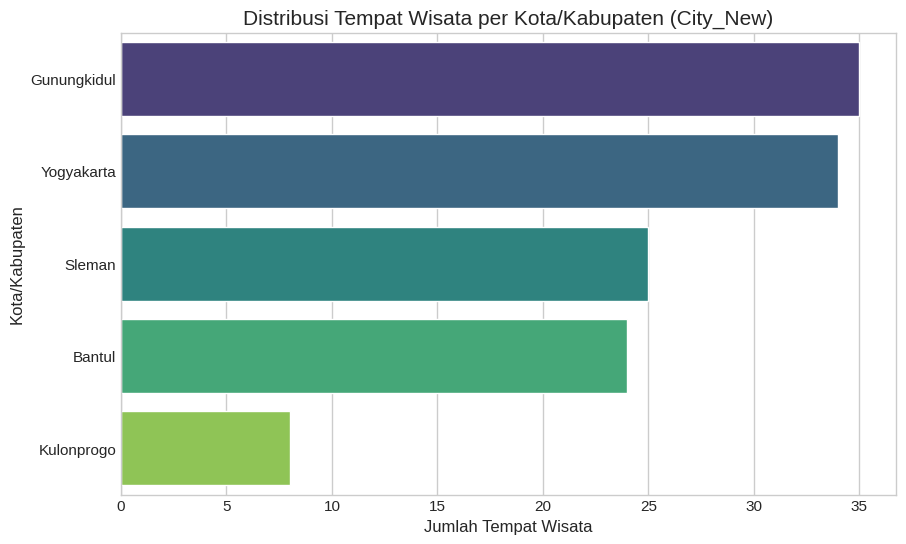

In [15]:
# --- 3.4. Visualisasi Distribusi Tempat Wisata per Kota/Kabupaten ---
if 'df_tour' in locals() and not df_tour.empty and 'City_New' in df_tour.columns:
    plt.figure(figsize=(10, 6)) # Sedikit menyesuaikan ukuran agar lebih pas
    sns.countplot(y=df_tour['City_New'], order = df_tour['City_New'].value_counts().index, palette='viridis')
    plt.title('Distribusi Tempat Wisata per Kota/Kabupaten (City_New)', fontsize=15)
    plt.xlabel('Jumlah Tempat Wisata', fontsize=12)
    plt.ylabel('Kota/Kabupaten', fontsize=12)
    plt.show()
else:
    print("⚠️ DataFrame 'df_tour' atau kolom 'City_New' belum terdefinisi.")

**Insight**

Distribusi Tempat Wisata per Kota/Kabupaten

- Gunungkidul memiliki jumlah tempat wisata yang paling banyak, jauh melebihi kota/kabupaten lainnya.
- Yogyakarta menempati urutan kedua dengan jumlah tempat wisata yang cukup banyak, menunjukkan Yogyakarta sebagai pusat wisata utama.
- Sleman dan Bantul memiliki jumlah yang relatif seimbang, meskipun sedikit lebih rendah dari Yogyakarta.
- Kulonprogo memiliki jumlah tempat wisata yang paling sedikit, yang mungkin menunjukkan bahwa daerah ini belum menjadi fokus utama dalam pengembangan sektor pariwisata dibandingkan dengan daerah lain.

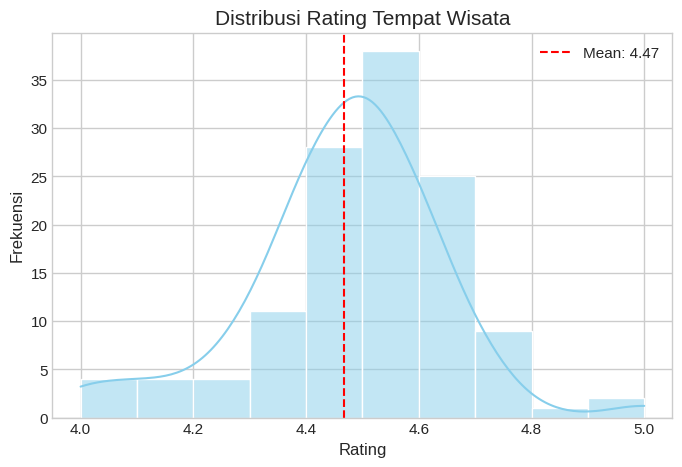

In [16]:
# --- 3.5. Visualisasi Distribusi Rating Tempat Wisata ---
if 'df_tour' in locals() and not df_tour.empty and 'Rating' in df_tour.columns:
    plt.figure(figsize=(8, 5)) # Sedikit menyesuaikan ukuran
    sns.histplot(df_tour['Rating'], bins=10, kde=True, color='skyblue')
    plt.title('Distribusi Rating Tempat Wisata', fontsize=15)
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('Frekuensi', fontsize=12)
    plt.axvline(df_tour['Rating'].mean(), color='red', linestyle='dashed', linewidth=1.5, label=f"Mean: {df_tour['Rating'].mean():.2f}")
    plt.legend()
    plt.show()
else:
    print("⚠️ DataFrame 'df_tour' atau kolom 'Rating' belum terdefinisi.")

**Insights**

Berdasarkan grafik distribusi rating tempat wisata, dapat dilihat bahwa mayoritas rating terkonsentrasi pada angka 4.4 hingga 4.6, dengan puncak distribusi berada di sekitar rating 4.5. Hal ini menunjukkan bahwa sebagian besar tempat wisata mendapat penilaian yang sangat baik.

Dengan rata-rata rating 4.47, dapat disimpulkan bahwa sebagian besar pengunjung merasa puas dengan tempat wisata yang mereka kunjungi, meskipun ada sedikit tempat yang mendapat rating lebih rendah atau sangat tinggi. Grafik ini juga menggambarkan kemiringan positif, di mana semakin banyak tempat wisata yang mendapat rating mendekati 5.

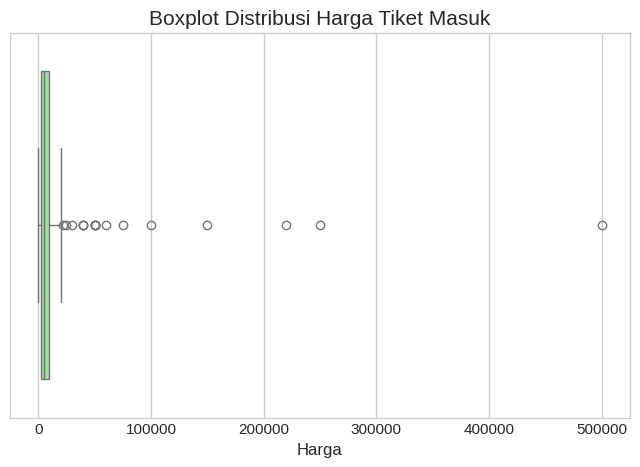

In [17]:
# --- 3.6. Visualisasi Distribusi Harga Tiket Masuk (Boxplot) ---
if 'df_tour' in locals() and not df_tour.empty and 'Price' in df_tour.columns:
    plt.figure(figsize=(8, 5)) # Sedikit menyesuaikan ukuran
    sns.boxplot(x=df_tour['Price'], color='lightgreen')
    plt.title('Boxplot Distribusi Harga Tiket Masuk', fontsize=15)
    plt.xlabel('Harga', fontsize=12)
    plt.show()
else:
    print("⚠️ DataFrame 'df_tour' atau kolom 'Price' belum terdefinisi.")

**Insights**

Boxplot menunjukkan bahwa sebagian besar harga tiket masuk tempat wisata berada pada rentang harga rendah hingga menengah, dengan beberapa outlier harga tinggi. Outlier ini relevan berdasarkan riset yang menunjukkan bahwa beberapa tempat wisata di Yogyakarta memang memiliki harga tiket yang lebih mahal, kemungkinan karena fasilitas eksklusif. Oleh karena itu, outlier ini tidak perlu dihapus, karena harga akan menjadi fitur penting dalam sistem rekomendasi berbasis konten.

#Bagian 4

In [18]:
# =================================================
# BAGIAN 4: DATA PREPARATION
# =================================================

# --- 4.1. Membuat Fitur Teks Gabungan (Content String) ---
if 'df_tour' in locals() and not df_tour.empty:
    df_tour['Content_String'] = (df_tour['Place_Name'] + ' ' +
                               df_tour['Description'] + ' ' +
                               df_tour['Category'] + ' ' +
                               df_tour['City_New']) # Menggunakan City_New yang sudah bersih

    print("✅ Kolom 'Content_String' berhasil dibuat.")
    print("\n--- Contoh 'Content_String' untuk tempat wisata pertama: ---")
    if not df_tour['Content_String'].empty:
        print(df_tour['Content_String'].iloc[0])
    else:
        print("⚠️ DataFrame 'Content_String' kosong.")
else:
    print("⚠️ DataFrame 'df_tour' belum terdefinisi atau kosong. Harap jalankan Blok 2 terlebih dahulu.")

✅ Kolom 'Content_String' berhasil dibuat.

--- Contoh 'Content_String' untuk tempat wisata pertama: ---
Taman Pintar Yogyakarta Taman Pintar Yogyakarta (bahasa Jawa: Hanacaraka,?????????????????????, Taman Pintar Ngayogyakarta) adalah wahana wisata yang terdapat di pusat Kota Yogyakarta, tepatnya di Jalan Panembahan Senopati No. 1-3, Yogyakarta, di kawasan Benteng Vredeburg. Taman ini memadukan tempat wisata rekreasi maupun edukasi dalam satu lokasi. Taman Pintar memiliki arena bermain sekaligus sarana edukasi yang terbagi dalam beberapa zona. Akses langsung kepada pusat buku eks Shopping Centre juga menambah nilai lebih Taman Pintar. Tempat rekreasi ini sangat baik untuk anak-anak pada masa perkembangan.\nBeberapa tahun ini Taman Pintar menjadi alternatif tempat berwisata bagi masyarakat Yogyakarta maupun luar kota.Taman ini, khususnya pada wahana pendidikan anak usia dini dilengkapi dengan teknologi interaktif digital serta pemetaan video yang akan memacu imajinasi anak serta keterta

In [19]:
# --- 4.2. Mengubah Teks menjadi Vektor dengan TF-IDF ---
if 'df_tour' in locals() and not df_tour.empty and 'Content_String' in df_tour.columns:
    stop_words_indonesia = ['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir',
                           'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara',
                           'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal',
                           'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan',
                           'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya',
                           'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini',
                           'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja',
                           'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada',
                           'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun',
                           'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya',
                           'berjumlah', 'berkali-kali', 'berkata', 'berkehendak', 'berkeinginan', 'berkenaan', 'berlainan',
                           'berlalu', 'berlangsung', 'berlebihan', 'bermacam', 'bermacam-macam', 'bermaksud', 'bermula',
                           'bersama', 'bersama-sama', 'bersiap', 'bersiap-siap', 'bertanya', 'bertanya-tanya',
                           'berturut', 'berturut-turut', 'bertutur', 'berujar', 'berupa', 'besar', 'betul', 'betulkah',
                           'biasa', 'biasanya', 'bila', 'bilakah', 'bisa', 'bisakah', 'boleh', 'bolehkah', 'bolehlah',
                           'buat', 'bukan', 'bukankah', 'bukanlah', 'bukannya', 'bulan', 'bung', 'cara', 'caranya',
                           'cukup', 'cukupkah', 'cukuplah', 'cuma', 'dahulu', 'dalam', 'dan', 'dapat', 'dari', 'daripada',
                           'datang', 'dekat', 'demi', 'demikian', 'demikianlah', 'dengan', 'depan', 'di', 'dia', 'diakhiri',
                           'diakhirinya', 'dialah', 'diantara', 'diantaranya', 'diberi', 'diberikan', 'diberikannya',
                           'dibuat', 'dibuatnya', 'didapat', 'didatangkan', 'digunakan', 'diibaratkan', 'diibaratkannya',
                           'diingat', 'diingatkan', 'diinginkan', 'dijawab', 'dijelaskan', 'dijelaskannya', 'dikarenakan',
                           'dikatakan', 'dikatakannya', 'dikerjakan', 'diketahui', 'diketahuinya', 'dikhususkan',
                           'dilakukan', 'dilalui', 'dilihat', 'dimaksud', 'dimaksudkan', 'dimaksudkannya', 'dimaksudnya',
                           'diminta', 'dimintai', 'dimisalkan', 'dimulai', 'dimulailah', 'dimulainya', 'dimungkinkan',
                           'dini', 'dipastikan', 'diperbuat', 'diperbuatnya', 'dipergunakan', 'diperkirakan', 'diperlihatkan',
                           'diperlukan', 'diperlukannya', 'dipersoalkan', 'dipertanyakan', 'dipunyai', 'diri', 'dirinya',
                           'disampaikan', 'disebut', 'disebutkan', 'disebutkannya', 'disini', 'disinilah', 'ditambahkan',
                           'ditandaskan', 'ditanya', 'ditanyai', 'ditanyakan', 'ditegaskan', 'ditujukan', 'ditunjuk',
                           'ditunjuki', 'ditunjukkan', 'ditunjukkannya', 'ditunjuknya', 'dituturkan', 'dituturkannya',
                           'diucapkan', 'diucapkannya', 'diungkapkan', 'dong', 'dua', 'dulu', 'empat', 'enggak', 'enggaknya',
                           'entah', 'entahlah', 'guna', 'gunakan', 'hal', 'hampir', 'hanya', 'hanyalah', 'hari', 'harus',
                           'haruslah', 'harusnya', 'hendak', 'hendaklah', 'hendaknya', 'hingga', 'ia', 'ialah', 'ibarat',
                           'ibaratkan', 'ibaratnya', 'ibu', 'ikut', 'ingat', 'ingat-ingat', 'ingin', 'inginkah', 'inginkan',
                           'ini', 'inikah', 'inilah', 'itu', 'itukah', 'itulah', 'jadi', 'jadilah', 'jadinya', 'jangan',
                           'jangankan', 'janganlah', 'jauh', 'jawab', 'jawaban', 'jawabnya', 'jelas', 'jelaskan', 'jelaslah',
                           'jelasnya', 'jika', 'jikalau', 'juga', 'jumlah', 'jumlahnya', 'justru', 'kala', 'kalau',
                           'kalaulah', 'kalaupun', 'kali', 'kalian', 'kami', 'kamilah', 'kamu', 'kamulah', 'kan', 'kapan',
                           'kapankah', 'kapanpun', 'karena', 'karenanya', 'kasus', 'kata', 'katakan', 'katakanlah',
                           'katanya', 'ke', 'keadaan', 'kebetulan', 'kecil', 'kedua', 'keduanya', 'keinginan', 'kelamaan',
                           'kelihatan', 'kelihatannya', 'kelima', 'keluar', 'kembali', 'kemudian', 'kemungkinan',
                           'kemungkinannya', 'kenapa', 'kepada', 'kepadanya', 'keterlaluan', 'ketika', 'khususnya',
                           'kini', 'kinilah', 'kira', 'kira-kira', 'kiranya', 'kita', 'kitalah', 'kok', 'lagi', 'lagian',
                           'lah', 'lain', 'lainnya', 'lalu', 'lama', 'lamanya', 'lanjut', 'lanjutnya', 'lebih', 'lewat',
                           'lima', 'luar', 'macam', 'maka', 'makanya', 'makin', 'malah', 'malahan', 'mampu', 'mampukah',
                           'mana', 'manakala', 'manalagi', 'masa', 'masalah', 'masalahnya', 'masih', 'masihkah', 'masing',
                           'masing-masing', 'mau', 'maupun', 'melainkan', 'melakukan', 'melalui', 'melihat', 'melihatnya',
                           'memang', 'memastikan', 'memberi', 'memberikan', 'membuat', 'memerlukan', 'memihak',
                           'meminta', 'memintakan', 'memisalkan', 'memperbuat', 'mempergunakan', 'memperkirakan',
                           'memperlihatkan', 'mempersiapkan', 'mempersoalkan', 'mempertanyakan', 'mempunyai',
                           'memulai', 'memungkinkan', 'menaiki', 'menambahkan', 'menandaskan', 'menanti',
                           'menanti-nanti', 'menantikan', 'menanya', 'menanyai', 'menanyakan', 'mendapat', 'mendapatkan',
                           'mendatang', 'mendatangi', 'mendatangkan', 'menegaskan', 'mengakhiri', 'mengapa',
                           'mengatakan', 'mengatakannya', 'mengenai', 'mengerjakan', 'mengetahui', 'menggunakan',
                           'menghendaki', 'mengibaratkan', 'mengibaratkannya', 'mengingat', 'mengingatkan',
                           'menginginkan', 'mengira', 'mengucapkan', 'mengucapkannya', 'mengungkapkan', 'menjadi',
                           'menjawab', 'menjelaskan', 'menuju', 'menunjuk', 'menunjuki', 'menunjukkan', 'menunjuknya',
                           'menurut', 'menuturkan', 'menyampaikan', 'menyangkut', 'menyatakan', 'menyebutkan',
                           'menyeluruh', 'menyiapkan', 'merasa', 'mereka', 'merekalah', 'merupakan', 'meski',
                           'meskipun', 'meyakini', 'meyakinkan', 'minta', 'mirip', 'misal', 'misalkan', 'misalnya',
                           'mula', 'mulai', 'mulailah', 'mulanya', 'mungkin', 'mungkinkah', 'nah', 'naik', 'namun',
                           'nanti', 'nantinya', 'nyaris', 'nyatanya', 'oleh', 'olehnya', 'pada', 'padahal', 'padanya',
                           'pak', 'paling', 'panjang', 'pantas', 'para', 'pasti', 'pastilah', 'penting', 'pentingnya',
                           'per', 'percuma', 'perlu', 'perlukah', 'perlunya', 'pernah', 'persoalan', 'pertama',
                           'pertama-tama', 'pertanyaan', 'pertanyakan', 'pihak', 'pihaknya', 'pukul', 'pula', 'pun',
                           'punya', 'rasa', 'rasanya', 'rata', 'rata-rata', 'rupa', 'rupanya', 'saat', 'saatnya', 'saja',
                           'sajalah', 'saling', 'sama', 'sama-sama', 'sambil', 'sampai', 'sampai-sampai', 'sampaikan',
                           'sana', 'sangat', 'sangatlah', 'sangkut', 'satu', 'saya', 'sayalah', 'se', 'sebab', 'sebabnya',
                           'sebagai', 'sebagaimana', 'sebagainya', 'sebagian', 'sebaik', 'sebaik-baiknya', 'sebaiknya',
                           'sebaliknya', 'sebanyak', 'sebegini', 'sebegitu', 'sebelum', 'sebelumnya', 'sebenarnya',
                           'seberapa', 'sebesar', 'sebetulnya', 'sebisanya', 'sebuah', 'sebut', 'sebutlah',
                           'sebutnya', 'secara', 'secukupnya', 'sedang', 'sedangkan', 'sedemikian', 'sedikit',
                           'sedikitnya', 'seenaknya', 'segala', 'segalanya', 'segera', 'seharusnya', 'sehingga',
                           'seingat', 'sejak', 'sejauh', 'sejenak', 'sejumlah', 'sekadar', 'sekadarnya', 'sekali',
                           'sekali-kali', 'sekalian', 'sekaligus', 'sekalipun', 'sekarang', 'sekaranglah',
                           'sekecil', 'seketika', 'sekiranya', 'sekitar', 'sekitarnya', 'sekurang-kurangnya',
                           'sekurangnya', 'sela', 'selagi', 'selain', 'selaku', 'selalu', 'selama', 'selama-lamanya',
                           'selamanya', 'selanjutnya', 'seluruh', 'seluruhnya', 'semacam', 'semakin', 'semampu',
                           'semampunya', 'semasa', 'semasih', 'semata', 'semata-mata', 'semaunya', 'sementara',
                           'semisal', 'semisalnya', 'sempat', 'semua', 'semuanya', 'semula', 'sendiri', 'sendirian',
                           'sendirinya', 'seolah', 'seolah-olah', 'seorang', 'sepanjang', 'sepantasnya', 'sepantasnyalah',
                           'seperlunya', 'seperti', 'sepertinya', 'sepihak', 'sering', 'seringnya', 'serta', 'serupa',
                           'sesaat', 'sesama', 'sesampai', 'sesegera', 'sesekali', 'seseorang', 'sesuatu', 'sesuatunya',
                           'sesudah', 'sesudahnya', 'setelah', 'setempat', 'setengah', 'seterusnya', 'setiap',
                           'setiba', 'setibanya', 'setidak-tidaknya', 'setidaknya', 'setinggi', 'seusai', 'sewaktu',
                           'siapa', 'siapakah', 'siapapun', 'sini', 'sinilah', 'suatu', 'sudah', 'sudahkah', 'sudahlah',
                           'supaya', 'tadi', 'tadinya', 'tahu', 'tahun', 'tak', 'tama', 'tambah', 'tambahnya', 'tampak',
                           'tampaknya', 'tandas', 'tandasnya', 'tanpa', 'tanya', 'tanyakan', 'tanyanya', 'tapi',
                           'tegas', 'tegasnya', 'telah', 'tempat', 'tengah', 'tentang', 'tentu', 'tentulah', 'tentunya',
                           'tepat', 'terakhir', 'terasa', 'terbanyak', 'terbilang', 'terbuat', 'terdiri', 'terhadap',
                           'terhadapnya', 'teringat', 'teringat-ingat', 'terjadi', 'terjadilah', 'terjadinya', 'terkira',
                           'terlalu', 'terlebih', 'terlihat', 'termasuk', 'ternyata', 'tersampaikan', 'tersebut',
                           'tersebutlah', 'tertentu', 'tertuju', 'terus', 'terutama', 'tetap', 'tetapi', 'tiap', 'tiba',
                           'tiba-tiba', 'tidak', 'tidakkah', 'tidaklah', 'tiga', 'toh', 'tunjuk', 'turut', 'tutur',
                           'tuturnya', 'ucap', 'ucapnya', 'ujar', 'ujarnya', 'umum', 'umumnya', 'ungkap', 'ungkapnya',
                           'untuk', 'usah', 'usai', 'waduh', 'wah', 'wahai', 'waktu', 'waktunya', 'walau', 'walaupun',
                           'ya', 'yaitu', 'yakin', 'yakni', 'yang']

    tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=stop_words_indonesia)
    text_features = tfidf_vectorizer.fit_transform(df_tour['Content_String'])

    print("✅ TF-IDF Vectorizer berhasil dilatih (fit_transform).")
    print(f"Bentuk matriks fitur teks (TF-IDF): {text_features.shape}")
else:
    print("⚠️ DataFrame 'df_tour' atau kolom 'Content_String' belum terdefinisi.")

✅ TF-IDF Vectorizer berhasil dilatih (fit_transform).
Bentuk matriks fitur teks (TF-IDF): (126, 1000)


In [20]:
# --- 4.3. Menyamakan Skala Fitur Numerik ---
if 'df_tour' in locals() and not df_tour.empty:
    numeric_cols = ['Price', 'Rating']
    # Memastikan kolom numerik ada sebelum melakukan scaling
    if all(col in df_tour.columns for col in numeric_cols):
        scaler = StandardScaler()
        # .values mengubah DataFrame menjadi array numpy, .astype(float) untuk konsistensi tipe data
        numeric_features = scaler.fit_transform(df_tour[numeric_cols].values.astype(float))
        print("✅ StandardScaler berhasil dilatih (fit_transform) pada fitur numerik.")
        print(f"Bentuk matriks fitur numerik: {numeric_features.shape}")
    else:
        print(f"⚠️ Kolom numerik {numeric_cols} tidak ditemukan, langkah scaling dilewati.")
        numeric_features = np.array([]) # Buat array kosong jika kolom tidak ada
else:
    print("⚠️ DataFrame 'df_tour' belum terdefinisi atau kosong.")

✅ StandardScaler berhasil dilatih (fit_transform) pada fitur numerik.
Bentuk matriks fitur numerik: (126, 2)


In [21]:
# --- 4.4. Menggabungkan Semua Fitur ---
# Hanya lanjutkan jika kedua jenis fitur berhasil dibuat
if 'text_features' in locals() and 'numeric_features' in locals() and numeric_features.size > 0:
    # Mengubah fitur numerik yang sudah di-scale menjadi format sparse matrix
    numeric_features_sparse = csr_matrix(numeric_features)

    # Menggabungkan matriks fitur teks dan matriks fitur numerik secara horizontal
    combined_features = hstack([text_features, numeric_features_sparse])
    print("✅ Fitur teks dan numerik berhasil digabungkan.")
elif 'text_features' in locals():
    combined_features = text_features # Jika hanya ada fitur teks
    print("✅ Hanya fitur teks yang digunakan (fitur numerik tidak ada/gagal di-scale).")
else:
    print("⚠️ Tidak ada fitur yang berhasil dibuat untuk digabungkan. Pastikan Blok 4.2 dan 4.3 berjalan sukses.")
    combined_features = None # Untuk menandakan tidak ada fitur

✅ Fitur teks dan numerik berhasil digabungkan.


In [22]:
# --- 4.5. Verifikasi Hasil Akhir Feature Engineering ---
if 'combined_features' in locals() and combined_features is not None:
    print("\n--- Verifikasi Hasil Akhir Feature Engineering ---")
    print(f"Bentuk matriks fitur gabungan (Jumlah Data, Jumlah Fitur): {combined_features.shape}")

    # Menampilkan jumlah fitur dari masing-masing sumber
    if 'text_features' in locals():
        print(f"Jumlah fitur dari TF-IDF: {text_features.shape[1]}")
    if 'numeric_features' in locals() and numeric_features.size > 0:
        print(f"Jumlah fitur numerik: {numeric_features.shape[1]}")
else:
    print("⚠️ Variabel 'combined_features' belum terdefinisi. Pastikan Blok 4.4 berjalan sukses.")


--- Verifikasi Hasil Akhir Feature Engineering ---
Bentuk matriks fitur gabungan (Jumlah Data, Jumlah Fitur): (126, 1002)
Jumlah fitur dari TF-IDF: 1000
Jumlah fitur numerik: 2


#Bagian 5

In [23]:
# =================================================
# BAGIAN 5: MODELLING
# =================================================

# --- 5.1. Definisi Arsitektur Model Autoencoder ---
if 'combined_features' in locals() and combined_features is not None:
    input_dim = combined_features.shape[1]  # Dimensi input adalah jumlah fitur gabungan
    embedding_dim = 32  # Kita targetkan embedding 32 dimensi, ini bisa dieksperimenkan

    print(f"Dimensi input untuk model: {input_dim}")
    print(f"Dimensi embedding yang ditargetkan: {embedding_dim}")

    # --- Definisi Arsitektur Autoencoder ---
    # Input Layer
    input_layer = layers.Input(shape=(input_dim,), name='InputLayer')

    # Encoder
    # Lapisan pertama encoder, mengurangi dimensi ke 128
    encoded = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(input_layer)
    encoded = layers.Dropout(0.2)(encoded) # Dropout untuk regularisasi
    # Lapisan kedua encoder, mengurangi dimensi ke 64
    encoded = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoded)
    encoded = layers.Dropout(0.2)(encoded)
    # Lapisan Embedding: Ini adalah output dari encoder
    encoded_output = layers.Dense(embedding_dim, activation='relu', name='EmbeddingLayer', kernel_initializer='he_normal')(encoded)

    # Decoder
    # Lapisan pertama decoder, memperbesar dimensi dari embedding ke 64
    decoded = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoded_output)
    # Lapisan kedua decoder, memperbesar dimensi ke 128
    decoded = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(decoded)
    # Lapisan Output Decoder: Merekonstruksi input asli
    decoded_output = layers.Dense(input_dim, activation='linear', name='OutputLayer', kernel_initializer='he_normal')(decoded) # Aktivasi linear untuk rekonstruksi

    # --- Membuat Model ---
    # Model Autoencoder (digunakan untuk training)
    autoencoder = models.Model(inputs=input_layer, outputs=decoded_output, name='Autoencoder_Detailed')

    # Model Encoder (digunakan untuk menghasilkan embedding setelah training)
    encoder_model = models.Model(inputs=input_layer, outputs=encoded_output, name='Encoder_Detailed')

    print("\n✅ Arsitektur model Autoencoder dan Encoder berhasil didefinisikan.")
else:
    print("⚠️ Variabel 'combined_features' belum terdefinisi. Harap jalankan Blok 4 (Feature Engineering) terlebih dahulu.")

Dimensi input untuk model: 1002
Dimensi embedding yang ditargetkan: 32

✅ Arsitektur model Autoencoder dan Encoder berhasil didefinisikan.


In [24]:
# --- 5.2. Kompilasi Model ---
# Memastikan model autoencoder sudah terdefinisi
if 'autoencoder' in locals():
    # Mengompilasi model Autoencoder
    # Optimizer 'adam' adalah pilihan umum yang baik untuk banyak kasus.
    # Loss 'mse' (Mean Squared Error) cocok untuk masalah rekonstruksi.
    autoencoder.compile(optimizer='adam', loss='mse')

    print("✅ Model Autoencoder berhasil dikompilasi.")
else:
    print("⚠️ Model 'autoencoder' belum terdefinisi. Harap jalankan Blok 5.1 terlebih dahulu.")

✅ Model Autoencoder berhasil dikompilasi.


In [25]:
# --- 5.3. Menampilkan Ringkasan Arsitektur Model ---
if 'autoencoder' in locals():
    print("\n--- Ringkasan Arsitektur Autoencoder ---")
    autoencoder.summary()
else:
    print("⚠️ Model 'autoencoder' belum terdefinisi atau belum dikompilasi. Harap jalankan Blok 5.1 dan 5.2.")


--- Ringkasan Arsitektur Autoencoder ---


Model: "Autoencoder_Detailed"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, 1002)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       128,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EmbeddingLayer (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 1002)           │       129,258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,410 (1.06 MB)

 Trainable params: 278,410 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# --- 5.4. Pembagian Data untuk Training dan Testing ---
if 'combined_features' in locals() and combined_features is not None:
    # Mengubah data sparse menjadi dense array (numpy array)
    X_dense = combined_features.toarray()

    # Membagi data menjadi 80% untuk training dan 20% untuk testing
    # random_state digunakan agar pembagian data selalu sama setiap kali kode dijalankan
    X_train, X_test = train_test_split(X_dense, test_size=0.2, random_state=42)

    print("✅ Data berhasil dibagi menjadi set training dan testing.")
    print(f"Bentuk X_train: {X_train.shape}")
    print(f"Bentuk X_test: {X_test.shape}")
else:
    print("⚠️ Variabel 'combined_features' belum terdefinisi. Harap jalankan Blok 4 (Feature Engineering) terlebih dahulu.")

✅ Data berhasil dibagi menjadi set training dan testing.
Bentuk X_train: (100, 1002)
Bentuk X_test: (26, 1002)


In [27]:
# --- 5.5. Pelatihan Model (Training) ---
if 'X_train' in locals() and 'X_test' in locals() and 'autoencoder' in locals():
    print("--- Memulai Proses Pelatihan Model Autoencoder ---")

    # Callback untuk menghentikan training jika tidak ada peningkatan pada val_loss
    # patience=15 berarti kita akan menunggu 15 epoch untuk melihat apakah ada perbaikan
    # restore_best_weights=True akan mengembalikan bobot model ke kondisi terbaiknya saat berhenti
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15, # Jumlah epoch untuk menunggu sebelum berhenti jika tidak ada peningkatan
        restore_best_weights=True,
        verbose=1
    )

    # Melatih model Autoencoder
    history = autoencoder.fit(
        X_train, X_train, # Input dan target sama untuk autoencoder
        epochs=200,          # Jumlah maksimum epoch
        batch_size=16,       # Jumlah sampel per pembaruan bobot
        shuffle=True,        # Acak data training di setiap epoch
        validation_data=(X_test, X_test), # Data untuk validasi
        callbacks=[early_stopping],       # Menggunakan callback EarlyStopping
        verbose=1            # Tampilkan progress bar (1) atau silent (0)
    )

    print("\n✅ Proses pelatihan model selesai.")
else:
    print("⚠️ Variabel data training/testing atau model autoencoder belum terdefinisi. Harap jalankan blok sebelumnya.")

--- Memulai Proses Pelatihan Model Autoencoder ---
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0107 - val_loss: 0.0031
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 12/200
7/7 ━━━━━━

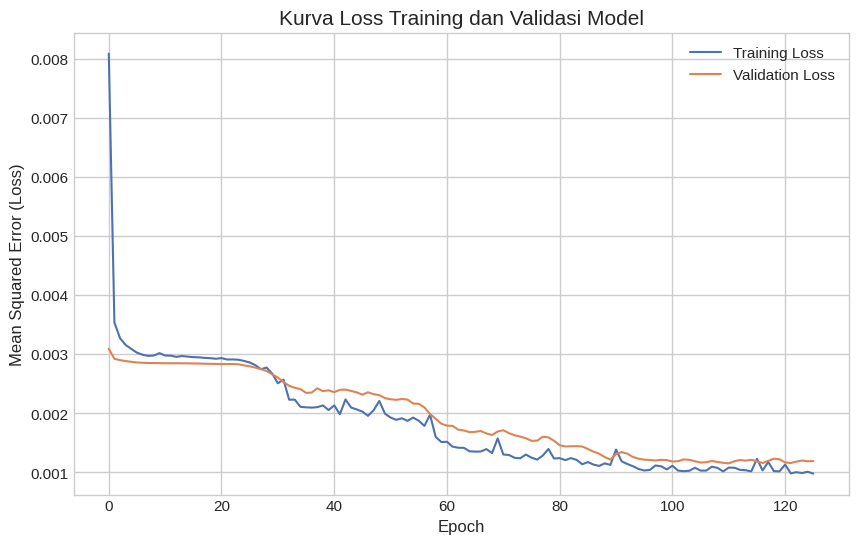

In [28]:
# --- 5.6. Visualisasi Kurva Loss Training dan Validasi ---
if 'history' in locals():
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Kurva Loss Training dan Validasi Model', fontsize=15)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Mean Squared Error (Loss)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠️ Variabel 'history' hasil pelatihan belum ada. Pastikan Blok 5.5 berjalan sukses.")

#Bagian 6

In [29]:
# --- 6.1. Menghasilkan Embedding untuk Seluruh Data ---
if 'encoder_model' in locals() and 'combined_features' in locals() and combined_features is not None:
    print("--- Menghasilkan Embedding untuk Seluruh Data ---")

    # Mengubah combined_features (sparse matrix) menjadi dense array untuk input ke encoder_model
    # Pastikan X_dense_all menggunakan combined_features yang sudah di-fit_transform dengan benar
    X_dense_all = combined_features.toarray()

    # Menghasilkan embedding menggunakan encoder_model
    all_embeddings = encoder_model.predict(X_dense_all)

    print(f"✅ Embedding berhasil dihasilkan untuk {all_embeddings.shape[0]} tempat wisata.")
    print(f"Bentuk matriks embedding: (Jumlah Data, Dimensi Embedding) = {all_embeddings.shape}")
    print("\nContoh 5 elemen pertama dari embedding untuk tempat wisata pertama:")
    print(all_embeddings[0, :5])
else:
    print("⚠️ Variabel 'encoder_model' atau 'combined_features' belum terdefinisi. Harap jalankan blok-blok sebelumnya dengan benar.")

--- Menghasilkan Embedding untuk Seluruh Data ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
✅ Embedding berhasil dihasilkan untuk 126 tempat wisata.
Bentuk matriks embedding: (Jumlah Data, Dimensi Embedding) = (126, 32)

Contoh 5 elemen pertama dari embedding untuk tempat wisata pertama:
[0.         0.         0.         0.00302138 0.        ]


In [30]:
# --- 6.2. Menghitung Matriks Cosine Similarity ---
if 'all_embeddings' in locals() and 'df_tour' in locals() and not df_tour.empty:
    print("\n--- Menghitung Matriks Cosine Similarity dari Embeddings ---")

    # Menghitung cosine similarity
    cosine_sim_matrix = cosine_similarity(all_embeddings)

    # Membuat DataFrame dari matriks similaritas untuk kemudahan pembacaan dan akses
    # Index dan kolom DataFrame ini adalah nama-nama tempat wisata
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=df_tour['Place_Name'], columns=df_tour['Place_Name'])

    print(f"✅ Matriks Cosine Similarity berhasil dibuat.")
    print(f"Bentuk matriks similaritas: {cosine_sim_df.shape}")
else:
    print("⚠️ Variabel 'all_embeddings' atau 'df_tour' belum terdefinisi. Harap jalankan Blok 6.1 terlebih dahulu.")


--- Menghitung Matriks Cosine Similarity dari Embeddings ---
✅ Matriks Cosine Similarity berhasil dibuat.
Bentuk matriks similaritas: (126, 126)


In [31]:
# --- 6.3. Menampilkan Contoh Skor Similaritas ---
if 'cosine_sim_df' in locals() and 'df_tour' in locals() and not df_tour.empty:
    if not cosine_sim_df.empty:
        place_example_for_similarity = df_tour['Place_Name'].iloc[0]
        print(f"\n--- Contoh beberapa skor similaritas untuk '{place_example_for_similarity}': ---")
        # Menampilkan 5 skor similaritas teratas (termasuk dengan dirinya sendiri)
        display(cosine_sim_df.loc[place_example_for_similarity].sort_values(ascending=False).head())
    else:
        print("⚠️ DataFrame 'cosine_sim_df' kosong.")
else:
    print("⚠️ Variabel 'cosine_sim_df' atau 'df_tour' belum terdefinisi. Harap jalankan Blok 6.2 terlebih dahulu.")


--- Contoh beberapa skor similaritas untuk 'Taman Pintar Yogyakarta': ---


,Taman Pintar Yogyakarta
Place_Name,
Taman Pintar Yogyakarta,1.000000
Bentara Budaya Yogyakarta (BBY),0.980361
Keraton Yogyakarta,0.976118
Jurang Tembelan Kanigoro,0.975106
Museum Sonobudoyo Unit I,0.974467


#Bagian 7

In [32]:
# --- 7.1. Definisi Fungsi Rekomendasi (Dimodifikasi untuk Fitur Pencarian) ---
if 'cosine_sim_df' in locals() and 'df_tour' in locals() and not df_tour.empty:

    def get_place_recommendations(place_name, similarity_df, items_df, k=10):
        """
        Fungsi untuk mendapatkan k rekomendasi tempat wisata teratas,
        dengan tempat yang dicari muncul di baris pertama.
        Pencarian sudah tidak sensitif terhadap huruf besar-kecil.

        Args:
            place_name (str): Nama tempat wisata yang ingin dicari rekomendasinya.
            similarity_df (pd.DataFrame): DataFrame matriks cosine similarity.
            items_df (pd.DataFrame): DataFrame asli yang berisi detail tempat wisata.
            k (int): Jumlah rekomendasi yang diinginkan (tidak termasuk item yang dicari).

        Returns:
            pd.DataFrame: DataFrame berisi tempat yang dicari dan k rekomendasinya.
                          Mengembalikan pesan error jika tempat tidak ditemukan.
        """
        # Buat index dictionary dalam format lowercase → original
        similarity_df_lower_index = {name.lower(): name for name in similarity_df.index}

        # Ubah nama input jadi lowercase untuk dicocokkan
        place_name_normalized = place_name.lower()

        # Cek apakah nama yang dicari ada
        if place_name_normalized not in similarity_df_lower_index:
            return f"⚠️ Tempat wisata '{place_name}' tidak ditemukan dalam data. Silakan cek kembali ejaan atau nama tempat."

        # Gunakan nama tempat asli (case-asli) dari index similarity_df
        actual_place_name = similarity_df_lower_index[place_name_normalized]

        # Ambil detail untuk tempat yang dicari
        searched_item_details = items_df[items_df['Place_Name'].str.lower() == place_name_normalized].copy()
        if searched_item_details.empty:
          return f"⚠️ Detail untuk tempat wisata '{place_name}' tidak ditemukan dalam items_df."

        # Tambahkan kolom Similarity_Score dengan nilai 1.0 untuk item yang dicari
        searched_item_details['Similarity_Score'] = 1.0

        # Mengambil skor similaritas untuk tempat yang dicari dan mengurutkannya
        sim_scores = similarity_df.loc[actual_place_name].sort_values(ascending=False)

        # Mengambil top-k indeks tempat wisata (mengabaikan item pertama karena itu adalah item itu sendiri)
        top_k_indices = sim_scores.iloc[1:k+1].index
        top_k_scores = sim_scores.iloc[1:k+1].values # Skor similaritasnya

        # Mengambil detail dari tempat-tempat yang direkomendasikan
        recommendations_df = items_df[items_df['Place_Name'].isin(top_k_indices)].copy()

        # Menambahkan skor similaritas ke DataFrame rekomendasi
        score_map = dict(zip(top_k_indices, top_k_scores))
        recommendations_df['Similarity_Score'] = recommendations_df['Place_Name'].map(score_map)

        # Mengurutkan rekomendasi berdasarkan Similarity_Score
        recommendations_df = recommendations_df.sort_values(by='Similarity_Score', ascending=False)

        # 5. Menggabungkan tempat yang dicari dengan rekomendasinya
        final_df = pd.concat([searched_item_details, recommendations_df], ignore_index=True)

        # Memilih dan mengatur urutan kolom yang ingin ditampilkan
        return final_df[['Place_Name', 'Category', 'City_New', 'Price', 'Rating', 'Similarity_Score']].reset_index(drop=True)

    print("✅ Fungsi 'get_place_recommendations' (dimodifikasi untuk pencarian) siap digunakan.")

else:
    print("⚠️ Variabel 'cosine_sim_df' atau 'df_tour' belum terdefinisi. Harap jalankan Blok 6 terlebih dahulu.")

✅ Fungsi 'get_place_recommendations' (dimodifikasi untuk pencarian) siap digunakan.


In [36]:
# --- 7.2. Proses Inferensi (Mendapatkan Rekomendasi dengan Tempat Dicari di Awal) ---
if 'get_place_recommendations' in locals() and 'cosine_sim_df' in locals() and 'df_tour' in locals():
    print("--- Melakukan Proses Inferensi untuk Mendapatkan Rekomendasi ---")

    # Contoh: Mendapatkan rekomendasi untuk 'Candi Sewu'
    place_to_recommend_example = 'Candi Sewu'
    # Anda bisa mencoba nama tempat lain dari df_tour['Place_Name'].unique()

    recommendations_result = get_place_recommendations(
        place_name=place_to_recommend_example,
        similarity_df=cosine_sim_df,
        items_df=df_tour,
        k=10  # Mendapatkan 10 rekomendasi teratas (selain item yang dicari)
    )

    if isinstance(recommendations_result, str):
        # Jika fungsi mengembalikan string (pesan error)
        print(recommendations_result)
    else:
        print(f"\n--- Hasil Pencarian dan Rekomendasi Teratas untuk '{place_to_recommend_example}' ---")
        display(recommendations_result)

        print("\n--- Analisis Singkat Hasil Rekomendasi ---")
        print(f"Tempat wisata yang Anda cari ('{place_to_recommend_example}') ditampilkan di baris pertama dengan skor similaritas 1.0 (terhadap dirinya sendiri).")
        print("Baris-baris berikutnya adalah tempat-tempat yang paling mirip berdasarkan model.")
        if len(recommendations_result) > 1:
            top_actual_recommendation = recommendations_result.iloc[1]
            print(f"Rekomendasi teratas (selain item pencarian) adalah '{top_actual_recommendation['Place_Name']}' "
                  f"dengan skor similaritas {top_actual_recommendation['Similarity_Score']:.4f}.")
        else:
            print("Tidak ada rekomendasi lain yang ditemukan.")
else:
    print("⚠️ Fungsi 'get_place_recommendations', 'cosine_sim_df', atau 'df_tour' belum terdefinisi. Harap jalankan Blok 7.1 (versi modifikasi) dan blok-blok sebelumnya.")

--- Melakukan Proses Inferensi untuk Mendapatkan Rekomendasi ---

--- Hasil Pencarian dan Rekomendasi Teratas untuk 'Candi Sewu' ---


,Place_Name,Category,City_New,Price,Rating,Similarity_Score
0,Candi Sewu,Budaya,Yogyakarta,50000,4.6,1.000000
1,Museum Ullen Sentalu,Budaya,Sleman,100000,4.7,0.988007
2,Candi Prambanan,Budaya,Sleman,50000,4.7,0.976121
3,Candi Ratu Boko,Budaya,Sleman,75000,4.6,0.966082
4,Candi Borobudur,Budaya,Yogyakarta,50000,4.7,0.933429
5,Kampung Wisata Dipowinatan,Budaya,Yogyakarta,220000,4.5,0.906545
6,Goa Jomblang,Cagar Alam,Gunungkidul,500000,4.6,0.900132
7,Gembira Loka Zoo,Cagar Alam,Yogyakarta,60000,4.5,0.899876
8,Bukit Panguk Kediwung,Budaya,Bantul,250000,4.5,0.893549
9,Monumen Batik Yogyakarta,Budaya,Yogyakarta,40000,4.5,0.886539



--- Analisis Singkat Hasil Rekomendasi ---
Tempat wisata yang Anda cari ('Candi Sewu') ditampilkan di baris pertama dengan skor similaritas 1.0 (terhadap dirinya sendiri).
Baris-baris berikutnya adalah tempat-tempat yang paling mirip berdasarkan model.
Rekomendasi teratas (selain item pencarian) adalah 'Museum Ullen Sentalu' dengan skor similaritas 0.9880.


In [37]:
# --- 7.3. Analisis Singkat Hasil Rekomendasi ---
if 'recommendations_result' in locals() and isinstance(recommendations_result, pd.DataFrame):
    if not recommendations_result.empty:
        print("\n--- Analisis Singkat Hasil Rekomendasi ---")
        print(f"Ketika mencari rekomendasi untuk '{place_to_recommend_example}':")
        top_recommendation = recommendations_result.iloc[0]
        print(f"Rekomendasi teratas adalah '{top_recommendation['Place_Name']}' "
              f"dengan skor similaritas {top_recommendation['Similarity_Score']:.4f}.")
        print("\nObservasi:")
        print("- Perhatikan kategori tempat wisata yang direkomendasikan. Apakah relevan?")
        print("- Bagaimana dengan lokasi (City_New)? Apakah tempat-tempat yang direkomendasikan berdekatan atau memiliki karakteristik area yang serupa?")
        print("- Apakah rentang harga dan rating dari tempat yang direkomendasikan masuk akal dibandingkan dengan tempat input?")
        print("- Skor similaritas yang bervariasi (tidak semua 1.0) menunjukkan bahwa embedding yang dihasilkan model sudah lebih baik dalam menangkap nuansa perbedaan antar tempat wisata.")
        print("\nUntuk laporan Anda, analisis lebih mendalam bisa dilakukan dengan membandingkan deskripsi teks atau fitur-fitur lain yang berkontribusi pada kemiripan ini.")
    else:
        print(f"Tidak ada rekomendasi yang dihasilkan untuk '{place_to_recommend_example}'.")
elif 'recommendations_result' in locals() and isinstance(recommendations_result, str):
    # Ini menangani kasus jika place_name tidak ditemukan
    print(f"\n--- Analisis Singkat Hasil Rekomendasi ---")
    print(recommendations_result) # Akan menampilkan pesan error dari fungsi
else:
    print("⚠️ Variabel 'recommendations_result' belum ada. Pastikan Blok 7.2 berjalan dengan sukses.")


--- Analisis Singkat Hasil Rekomendasi ---
Ketika mencari rekomendasi untuk 'Candi Sewu':
Rekomendasi teratas adalah 'Candi Sewu' dengan skor similaritas 1.0000.

Observasi:
- Perhatikan kategori tempat wisata yang direkomendasikan. Apakah relevan?
- Bagaimana dengan lokasi (City_New)? Apakah tempat-tempat yang direkomendasikan berdekatan atau memiliki karakteristik area yang serupa?
- Apakah rentang harga dan rating dari tempat yang direkomendasikan masuk akal dibandingkan dengan tempat input?
- Skor similaritas yang bervariasi (tidak semua 1.0) menunjukkan bahwa embedding yang dihasilkan model sudah lebih baik dalam menangkap nuansa perbedaan antar tempat wisata.

Untuk laporan Anda, analisis lebih mendalam bisa dilakukan dengan membandingkan deskripsi teks atau fitur-fitur lain yang berkontribusi pada kemiripan ini.


#Bagian 8

In [38]:
# --- 8.1. Menyimpan Model Encoder TensorFlow ---
if 'encoder_model' in locals():
    try:
        encoder_model.save('tourism_encoder.h5')
        print("✅ Model encoder (tourism_encoder.h5) berhasil disimpan.")
    except Exception as e:
        print(f"❌ Gagal menyimpan model encoder: {e}")
else:
    print("⚠️ Variabel 'encoder_model' belum terdefinisi. Harap jalankan Blok 5.1 terlebih dahulu.")

✅ Model encoder (tourism_encoder.h5) berhasil disimpan.


In [39]:
# --- 8.2. Menyimpan TF-IDF Vectorizer ---
if 'tfidf_vectorizer' in locals():
    try:
        joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')
        print("✅ TF-IDF Vectorizer (tfidf_vectorizer.joblib) berhasil disimpan.")
    except Exception as e:
        print(f"❌ Gagal menyimpan TF-IDF Vectorizer: {e}")
else:
    print("⚠️ Variabel 'tfidf_vectorizer' belum terdefinisi. Harap jalankan Blok 4.2 terlebih dahulu.")

✅ TF-IDF Vectorizer (tfidf_vectorizer.joblib) berhasil disimpan.


In [40]:
# --- 8.3. Menyimpan StandardScaler ---
if 'scaler' in locals():
    try:
        joblib.dump(scaler, 'scaler.joblib')
        print("✅ StandardScaler (scaler.joblib) berhasil disimpan.")
    except Exception as e:
        print(f"❌ Gagal menyimpan StandardScaler: {e}")
else:
    print("⚠️ Variabel 'scaler' belum terdefinisi. Harap jalankan Blok 4.3 terlebih dahulu.")

✅ StandardScaler (scaler.joblib) berhasil disimpan.


In [41]:
# --- 8.4. Menyimpan DataFrame Utama (Opsional) ---
if 'df_tour' in locals() and not df_tour.empty:
    try:
        df_tour.to_csv('tourism_data_final_for_inference.csv', index=False)
        print("✅ DataFrame utama (tourism_data_final_for_inference.csv) berhasil disimpan.")
    except Exception as e:
        print(f"❌ Gagal menyimpan DataFrame utama: {e}")
else:
    print("⚠️ DataFrame 'df_tour' belum terdefinisi atau kosong.")

print("\n--- Proses Penyimpanan Artefak Selesai ---")
print("File yang disimpan (jika berhasil):")
print("- tourism_encoder.h5 (Model Encoder)")
print("- tfidf_vectorizer.joblib (TF-IDF Vectorizer)")
print("- scaler.joblib (StandardScaler)")
print("- tourism_data_final_for_inference.csv (Data Wisata Final)")

✅ DataFrame utama (tourism_data_final_for_inference.csv) berhasil disimpan.

--- Proses Penyimpanan Artefak Selesai ---
File yang disimpan (jika berhasil):
- tourism_encoder.h5 (Model Encoder)
- tfidf_vectorizer.joblib (TF-IDF Vectorizer)
- scaler.joblib (StandardScaler)
- tourism_data_final_for_inference.csv (Data Wisata Final)
